# 02 - Factor models estimation & decomposition
This notebook contains:
- monthly factor model estimation for:
    - returns
    - log variance

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns
import missingno

import datetime as dt

from sklearn.linear_model import LinearRegression

import sys
sys.path.append('../')

import src

/home/fbrun/.local/lib/python3.6/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
sys.path.append('../../kungfu/')
import kungfu as kf

## Load Factor Data

In [4]:
df_spy = src.loader.load_spy()
df_factors = src.loader.load_factors()

## Return Series Factor Models
### Set up factor models

In [5]:
spy_capm = kf.FactorModel(df_spy['ret'].rename('spy'))
capm = kf.FactorModel(df_factors['mktrf'])
ff3 = kf.FactorModel(df_factors[['mktrf', 'smb', 'hml']])
c4 = kf.FactorModel(df_factors[['mktrf', 'smb', 'hml', 'umd']])

In [6]:
ret_models = {'spy_capm': spy_capm,
              'capm': capm,
              'ff3': ff3,
              'c4': c4,
             }

### Estimate

In [9]:
%%time
df_estimates = pd.DataFrame()
for year in range(1994, 2021):
    for month in range(1, 12+1):
        ## backwards part
        df_back = src.loader.load_monthly_crsp(year, month, which='back', column='retadj')
        df_back -= src.loader.load_rf(year=year, month=month, which='back').values
        sampling_date = df_back.index[-1]
        n_months = len(df_back.index.to_period('M').unique())
        
        # estimate
        back_estimates = src.factor.estimate_models(df_back, ret_models)
        back_estimates.index = pd.MultiIndex.from_product([[sampling_date], back_estimates.index], names=['sampling_date', 'permno'])
        back_estimates.columns = [column+'_back_{}M'.format(n_months) for column in back_estimates.columns]
       
        ## forward part
        df_forward = src.loader.load_monthly_crsp(year, month, which='forward', column='retadj')
        df_forward -= src.loader.load_rf(year=year, month=month, which='forward').values
        months = df_forward.index.to_period('M').unique().tolist()
        
        # estimate
        forward_estimates = pd.DataFrame(index=back_estimates.index)
        for i in range(1, len(months)+1):
            data = df_forward[df_forward.index.to_period('M').isin(months[0:i])]
            month_estimates = src.factor.estimate_models(data, ret_models)
            month_estimates.index = pd.MultiIndex.from_product([[sampling_date], month_estimates.index], names=['sampling_date', 'permno'])
            month_estimates.columns = [column+'_forward_{}M'.format(i) for column in month_estimates.columns]
            forward_estimates = forward_estimates.join(month_estimates)
                
        # combine
        estimates = back_estimates.join(forward_estimates)
        df_estimates = df_estimates.append(estimates)
    print('Done estimating year {}'.format(year))
        
    df_estimates.to_csv('../data/estimated/factor_exposures.csv')

Done estimating year 1994
Done estimating year 1995
Done estimating year 1996
Done estimating year 1997
Done estimating year 1998
Done estimating year 1999
Done estimating year 2000
Done estimating year 2001
Done estimating year 2002
Done estimating year 2003
Done estimating year 2004
Done estimating year 2005
Done estimating year 2006
Done estimating year 2007
Done estimating year 2008
Done estimating year 2009
Done estimating year 2010
Done estimating year 2011
Done estimating year 2012
Done estimating year 2013
Done estimating year 2014
Done estimating year 2015
Done estimating year 2016
Done estimating year 2017
Done estimating year 2018
Done estimating year 2019
Done estimating year 2020
CPU times: user 4h 12min 5s, sys: 18 s, total: 4h 12min 23s
Wall time: 4h 12min 38s


## Construct CAPM idiosyncratic variances

In [10]:
# load betas
betas = pd.read_csv('../data/estimated/factor_exposures.csv')
betas['sampling_date'] = pd.to_datetime(betas['sampling_date'])
betas = betas.set_index(['sampling_date','permno'])['spy_capm_spy_back_12M']

# load SPY data
spy_var = src.loader.load_spy(columns='var')

In [11]:
%%time
for year in range(1994, 2021):
    for month in range(1, 12+1):
        # period inputs
        total_variance = src.loader.load_monthly_crsp(year, month, which='back', column='var')
        period_betas = betas[(betas.index.get_level_values('sampling_date').year == year) & \
                             (betas.index.get_level_values('sampling_date').month == month)]
        period_spy_var = spy_var[spy_var.index.isin(total_variance.index)]

        # decompose
        df_decomposition = src.factor.decompose_variance(total_variance, period_betas, period_spy_var)
        df_decomposition.to_csv('../data/processed/monthly/{}/{}/df_var_decomposition.csv'.format(year, month))
        
    print('Done decomposiong year {}'.format(year))

Done decomposiong year 1994
Done decomposiong year 1995
Done decomposiong year 1996
Done decomposiong year 1997
Done decomposiong year 1998
Done decomposiong year 1999
Done decomposiong year 2000
Done decomposiong year 2001
Done decomposiong year 2002
Done decomposiong year 2003
Done decomposiong year 2004
Done decomposiong year 2005
Done decomposiong year 2006
Done decomposiong year 2007
Done decomposiong year 2008
Done decomposiong year 2009
Done decomposiong year 2010
Done decomposiong year 2011
Done decomposiong year 2012
Done decomposiong year 2013
Done decomposiong year 2014
Done decomposiong year 2015
Done decomposiong year 2016
Done decomposiong year 2017
Done decomposiong year 2018
Done decomposiong year 2019
Done decomposiong year 2020
CPU times: user 1min 17s, sys: 2.19 s, total: 1min 19s
Wall time: 1min 22s


## Variance Series Factor Models
### Set up factor models

In [7]:
logvar_capm = kf.FactorModel(np.log(df_spy['var']).rename('spy'))
var_models = {'logvar_capm': logvar_capm}

### Estimate

In [8]:
%%time
df_estimates = pd.DataFrame()
for year in range(1994, 2021):
    for month in range(1, 12+1):
        ## backwards part
        df_back = src.loader.load_monthly_crsp(year, month, which='back', column='var')
        df_back = np.log(df_back.replace(0, value=df_back.mask(df_back<=0).min()))
        sampling_date = df_back.index[-1]
        n_months = len(df_back.index.to_period('M').unique())
        
        # estimate
        back_estimates, back_residuals = src.factor.estimate_models(df_back, var_models, return_residuals=True)
        back_residuals.to_csv('../data/processed/monthly/{}/{}/df_back_residuals.csv'.format(year, month))
        back_estimates.index = pd.MultiIndex.from_product([[sampling_date], back_estimates.index], names=['sampling_date', 'permno'])
        back_estimates.columns = [column+'_back_{}M'.format(n_months) for column in back_estimates.columns]
       
        ## forward part
        df_forward = src.loader.load_monthly_crsp(year, month, which='forward', column='var')
        df_forward = np.log(df_forward.replace(0, value=df_forward.mask(df_forward<=0).min()))
        months = df_forward.index.to_period('M').unique().tolist()
        
        # estimate
        forward_estimates = pd.DataFrame(index=back_estimates.index)
        for i in range(1, len(months)+1):
            data = df_forward[df_forward.index.to_period('M').isin(months[0:i])]
            month_estimates = src.factor.estimate_models(data, var_models)
            month_estimates.index = pd.MultiIndex.from_product([[sampling_date], month_estimates.index], names=['sampling_date', 'permno'])
            month_estimates.columns = [column+'_forward_{}M'.format(i) for column in month_estimates.columns]
            forward_estimates = forward_estimates.join(month_estimates)
                
        # combine
        estimates = back_estimates.join(forward_estimates)
        df_estimates = df_estimates.append(estimates)
    print('Done estimating year {}'.format(year))
        
    df_estimates.to_csv('../data/estimated/logvar_factor_exposures.csv')

Done estimating year 1994
Done estimating year 1995
Done estimating year 1996
Done estimating year 1997


/home/fbrun/.local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1620: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/home/fbrun/.local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1685: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/fbrun/.local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1620: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/home/fbrun/.local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Done estimating year 1998
Done estimating year 1999
Done estimating year 2000
Done estimating year 2001
Done estimating year 2002
Done estimating year 2003
Done estimating year 2004
Done estimating year 2005
Done estimating year 2006
Done estimating year 2007
Done estimating year 2008
Done estimating year 2009
Done estimating year 2010
Done estimating year 2011
Done estimating year 2012
Done estimating year 2013
Done estimating year 2014
Done estimating year 2015
Done estimating year 2016
Done estimating year 2017
Done estimating year 2018
Done estimating year 2019
Done estimating year 2020
CPU times: user 1h 7min 22s, sys: 10.5 s, total: 1h 7min 32s
Wall time: 1h 7min 48s


## Analyse
### Beta Estimates

In [41]:
all_models = pd.read_csv('../data/estimated/factor_exposures.csv')
all_models['sampling_date'] = pd.to_datetime(all_models.sampling_date)

In [48]:
df_analysis = df_estimates.merge(all_models, left_index=True, right_on=['sampling_date','permno'], how='outer')\
                    [['logvar_capm_alpha_back_12M', 'logvar_capm_spy_back_12M',\
                      'capm_alpha_back_12M', 'capm_mktrf_back_12M']]

In [49]:
df_analysis['squared_betas'] = df_analysis['logvar_capm_spy_back_12M']**2

In [50]:
df_analysis.corr()

,logvar_capm_alpha_back_12M,logvar_capm_spy_back_12M,capm_alpha_back_12M,capm_mktrf_back_12M,squared_betas
logvar_capm_alpha_back_12M,1.000000,0.948686,0.075637,0.483448,0.919072
logvar_capm_spy_back_12M,0.948686,1.000000,-0.007807,0.300739,0.971558
capm_alpha_back_12M,0.075637,-0.007807,1.000000,0.154388,-0.006123
capm_mktrf_back_12M,0.483448,0.300739,0.154388,1.000000,0.300266
squared_betas,0.919072,0.971558,-0.006123,0.300266,1.000000


### Idiosyncratic Variance Residuals

In [17]:
year = 2011
month = 2

In [42]:
df_back_residuals = pd.read_csv('../data/processed/monthly/{}/{}/df_back_residuals.csv'.format(year, month))
df_var_decomposition = pd.read_csv('../data/processed/monthly/{}/{}/df_var_decomposition.csv'.format(year, month))

In [43]:
df_back_residuals['logvar_capm'].corr(np.log(df_var_decomposition['idiosyncratic']))

0.8262860484021962

In [38]:
correlations = pd.Series(index=pd.MultiIndex.from_product([[],[]]))
for year in range(1994, 2020):
    for month in range(1, 12+1):
        # load 
        df_back_residuals = pd.read_csv('../data/processed/monthly/{}/{}/df_back_residuals.csv'.format(year, month))
        df_var_decomposition = pd.read_csv('../data/processed/monthly/{}/{}/df_var_decomposition.csv'.format(year, month))
        
        # calculate
        correlation = df_back_residuals['logvar_capm'].corr(np.log(df_var_decomposition['idiosyncratic']))
        
        # collect
        correlations[(year,month)] = correlation

/home/rubelrennfix/.virtualenvs/euraculus/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


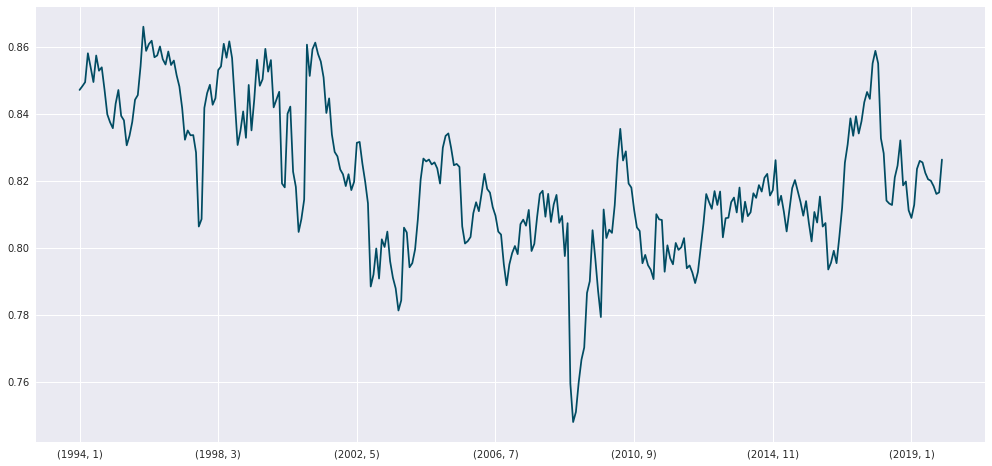

In [39]:
correlations.plot()

## Index correlation

In [55]:
df_indices = df_spy[['ret']].join(df_factors['rf']).join(df_factors['mktrf'])
df_indices['spy_excess'] = df_indices['ret'] - df_indices['rf']
df_indices[['spy_excess', 'mktrf']].corr()

,spy_excess,mktrf
spy_excess,1.000000,0.972954
mktrf,0.972954,1.000000


## Single year analysis
### Load data

In [37]:
year = 2019

In [5]:
df_returns = src.loader.load_year(year, data='returns')
df_volas = src.loader.load_year(year, data='volas')
df_spy_ret = src.loader.load_spy_returns(year)
df_spy_vola = src.loader.load_spy_vola(year)
rf = src.loader.load_rf(year)
tickers = src.loader.load_year_tickers(year)

In [39]:
returns, factors = df_returns, df_spy_ret
estimates = src.preprocess.estimate_factor_model(returns.subtract(rf.values), factors.subtract(rf.values))

volas, betas, factor_vola = df_volas, estimates['beta'], df_spy_vola
src.preprocess.decompose_vola(volas, betas, factor_vola)

,10104,10107,10145,10696,11308,11850,12060,12308,12490,13407,...,89626,90215,90319,91233,91937,92602,92611,92655,93002,93436
date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,NaN,0.001613,NaN,0.001345,0.002718,0.008497,0.024574,0.008694,0.007811,0.016117,...,0.003800,0.002058,0.005466,0.002896,0.010586,0.007104,0.005780,0.003393,0.003024,0.011830
2019-01-03,0.003096,0.004161,0.005488,0.004989,0.004047,0.005212,0.011572,0.007595,NaN,0.009777,...,0.008932,0.006438,0.008765,0.006419,0.007611,0.006859,0.004107,0.007077,0.016061,0.007758
2019-01-04,0.007019,0.004695,NaN,0.006579,0.004341,0.004058,0.002001,0.013805,0.001482,0.002370,...,0.005404,0.011146,0.007164,0.005150,0.006408,0.009174,0.005879,0.002368,NaN,0.009920
2019-01-07,0.007729,0.001491,0.002976,0.004082,0.004287,0.002796,0.013962,0.002778,0.000694,0.001064,...,0.003001,0.006435,NaN,NaN,0.005234,0.006926,0.003863,0.002589,0.008368,0.014002
2019-01-08,0.005219,0.003709,0.003371,0.005292,0.002534,NaN,0.014855,0.004175,NaN,0.005101,...,0.006704,0.004797,0.004249,0.003335,0.004358,0.001993,0.002309,0.004902,0.007986,0.012442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,0.002892,0.000741,0.001568,0.002182,0.001698,0.002140,0.002474,0.001406,0.001872,0.002177,...,0.002864,0.001405,0.001377,0.001354,0.001614,0.001757,0.001450,0.001976,0.001150,0.007929
2019-12-26,0.001473,0.001716,0.001333,0.002548,0.000984,0.001524,0.001786,0.003267,0.000539,0.002874,...,0.002571,0.001486,0.003130,0.000204,0.000109,0.002954,0.001717,0.001314,0.003714,0.004095
2019-12-27,0.001821,0.001503,0.000513,0.004131,0.002029,0.001124,0.000686,0.002899,0.001056,0.002501,...,0.003473,0.001917,0.002204,0.002453,0.001383,0.001801,0.001460,0.001016,0.002892,0.005333


### Compare zero innovation frequency for CAPM regression vs. Variance regression

In [8]:
def idiosyncratic_vola(year, steps=2):
    ''''''
    # setup
    index = src.loader.load_year(year, data='returns').columns
    df_estimates = pd.DataFrame(index=index)
    
    for step in range(steps):
        # load
        df_returns = src.loader.load_year(year, data='returns', data_year=year+step)
        df_volas = src.loader.load_year(year, data='volas', data_year=year+step)
        df_spy_ret = src.loader.load_spy_returns(year+step)
        df_spy_vola = src.loader.load_spy_vola(year+step)

        # estimate
        estimates = estimate_factor_model(df_returns, df_spy_ret)
        vola_estimates = estimate_factor_model(df_volas**2, df_spy_vola**2)
    
        # decompose
        idio_vola = decompose_vola(df_volas, estimates['beta'], df_spy_vola)
        idio_vola_direct = decompose_vola(df_volas, estimates['beta']**0.5, df_spy_vola)
    
    return idio_vola, idio_vola_direct

In [19]:
zero_count = pd.DataFrame(index=np.arange(1994, 2020), columns=['CAPM regression', 'Variance regression'])
for year in range(1994, 2020):
    CAPM, VOLA = idiosyncratic_vola(year, 1)
    zeros_CAPM = (CAPM==0).values.sum()
    zeros_VOLA = (VOLA==0).values.sum()
    zero_count.loc[year, 'CAPM regression'] = zeros_CAPM
    zero_count.loc[year, 'Variance regression'] = zeros_VOLA

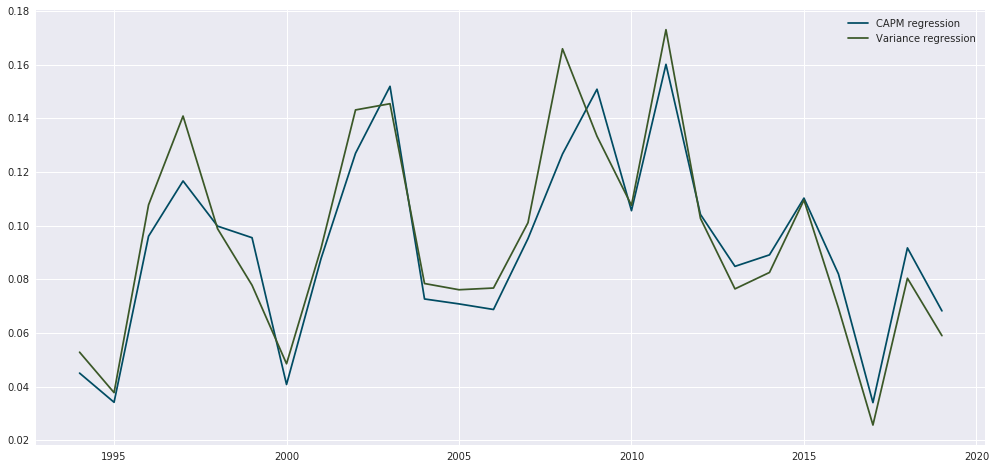

In [18]:
(zero_count/(250*100)).plot()

In [155]:
estimate_factor_model(df_volas, df_spy_vola).join(estimate_factor_model(df_returns, df_spy_ret), lsuffix='vola').corr()

,αvola,βvola,α,β
αvola,1.000000,0.029866,0.017806,0.316932
βvola,0.029866,1.000000,0.248434,0.883714
α,0.017806,0.248434,1.000000,0.228037
β,0.316932,0.883714,0.228037,1.000000


## OLD: Process all years

In [4]:
%%time
df_factor_model = pd.DataFrame()
for year in range(1994, 2020):
    # estimate
    if year == 2019:
        df_estimates = src.factor.idiosyncratic_vola(year, steps=1)
    else:
        df_estimates = src.factor.idiosyncratic_vola(year, steps=2)
    df_estimates.index = pd.MultiIndex.from_product([[year], df_estimates.index], names=['sampling_year', 'permno'])
    
    # collect
    df_factor_model = df_factor_model.append(df_estimates)
    
    # progress
    print('processed sampling year {}'.format(year))
    
df_factor_model.to_csv('../data/estimated/factor_models.csv')

processed sampling year 1994
processed sampling year 1995
processed sampling year 1996
processed sampling year 1997
processed sampling year 1998
processed sampling year 1999
processed sampling year 2000
processed sampling year 2001
processed sampling year 2002
processed sampling year 2003
processed sampling year 2004
processed sampling year 2005
processed sampling year 2006
processed sampling year 2007
processed sampling year 2008
processed sampling year 2009
processed sampling year 2010
processed sampling year 2011
processed sampling year 2012
processed sampling year 2013
processed sampling year 2014
processed sampling year 2015
processed sampling year 2016
processed sampling year 2017
processed sampling year 2018
processed sampling year 2019
CPU times: user 1min 4s, sys: 36.5 s, total: 1min 41s
Wall time: 1min 4s


## Statistical Factor Analysis

In [ ]:
from sklearn.decomposition import FactorAnalysis

In [40]:
def build_factor_model_residuals(year):
    # load
    df_returns = src.loader.load_year(year, data='returns', data_year=year).fillna(0)
    df_vola = src.loader.load_year(year, data='volas', data_year=year)
    df_idio = src.loader.load_year(year, data='idio_vola', data_year=year)
    rf = src.loader.load_rf(year)
    ff = src.loader.load_factors(year)

    # estimate factor models
    mm_estimates = src.factor.estimate_factor_model(df_returns.subtract(rf.values), ff[['mktrf']])
    ff3_estimates = src.factor.estimate_factor_model(df_returns.subtract(rf.values), ff[['mktrf', 'smb', 'hml']])
    c4_estimates = src.factor.estimate_factor_model(df_returns.subtract(rf.values), ff[['mktrf', 'smb', 'hml', 'umd']])

    fam = FactorAnalysis(n_components=5).fit(df_returns.T)
    facs = pd.DataFrame(fam.components_).T
    fam_estimates = src.factor.estimate_factor_model(df_returns.subtract(rf.values), facs)

    # construct residuals
    mm_residuals = df_returns - pd.DataFrame(index=ff.index, data={'alpha': 1}).join(ff[['mktrf']]) @ mm_estimates.T
    ff3_residuals = df_returns - pd.DataFrame(index=ff.index, data={'alpha': 1}).join(ff[['mktrf', 'smb', 'hml']]) @ ff3_estimates.T
    c4_residuals = df_returns - pd.DataFrame(index=ff.index, data={'alpha': 1}).join(ff[['mktrf', 'smb', 'hml', 'umd']]) @ c4_estimates.T
    fam_residuals = df_returns - pd.DataFrame(index=ff.index, data={'alpha': 1}).join(pd.DataFrame(index=ff.index, data=facs.values)) @ fam_estimates.T

    # save matrices
    mm_residuals.to_csv('../data/processed/annual/{}/mm_residuals_{}.csv'.format(year, year))
    ff3_residuals.to_csv('../data/processed/annual/{}/ff3_residuals_{}.csv'.format(year, year))
    c4_residuals.to_csv('../data/processed/annual/{}/c4_residuals_{}.csv'.format(year, year))
    fam_residuals.to_csv('../data/processed/annual/{}/fam_residuals_{}.csv'.format(year, year))

In [42]:
for year in range(1994, 2020):
    build_factor_model_residuals(year)
    print('Done building year {}'.format(year))

In [16]:

_ = FactorAnalysis(n_components=5).fit(df_returns.T)
facs = pd.DataFrame(_.components_).T

In [17]:
year = 2000
df_returns = src.loader.load_year(year, data='returns', data_year=year)
df_vola = src.loader.load_year(year, data='volas', data_year=year)
df_idio = src.loader.load_year(year, data='idio_vola', data_year=year)
rf = src.loader.load_rf(year)
ff = src.loader.load_factors(year)
estimates = src.factor.estimate_factor_model(df_returns.subtract(rf.values), facs)